# Subscriber Pipeline Project 

In [66]:
import sqlite3
import ast
import pandas as pd
import numpy as np

# Connect SQLite3 and Database

In [2]:
con = sqlite3.connect('cademycode.db')
cur = con.cursor()

#### View first row of table

In [4]:
tableone = cur.execute('''SELECT * FROM sqlite_master''').fetchone()
print(tableone)

('table', 'cademycode_students', 'cademycode_students', 2, 'CREATE TABLE cademycode_students (\n\tuuid INTEGER, \n\tname VARCHAR, \n\tdob VARCHAR, \n\tsex TEXT, \n\tcontact_info JSON, \n\tjob_id VARCHAR, \n\tnum_course_taken VARCHAR, \n\tcurrent_career_path_id VARCHAR, \n\ttime_spent_hrs VARCHAR\n)')


#### View table names

In [6]:
table_names = cur.execute('''SELECT name FROM sqlite_master WHERE type = 'table'; ''').fetchall()
print(table_names)

[('cademycode_students',), ('cademycode_courses',), ('cademycode_student_jobs',)]


#### Use pandas.read_sql_query to read each table in as a DataFrame

In [9]:
students = pd.read_sql_query('''SELECT * FROM cademycode_students''', con)
courses = pd.read_sql_query('''SELECT * FROM cademycode_courses''', con)
student_jobs = pd.read_sql_query('''SELECT * FROM cademycode_student_jobs''', con)

# Inspect and Clean Data

## Student Table

The `student` table is the largest one so I want to spend my time there first

In [24]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64


In [19]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   uuid                    5000 non-null   int64 
 1   name                    5000 non-null   object
 2   dob                     5000 non-null   object
 3   sex                     5000 non-null   object
 4   contact_info            5000 non-null   object
 5   job_id                  4995 non-null   object
 6   num_course_taken        4749 non-null   object
 7   current_career_path_id  4529 non-null   object
 8   time_spent_hrs          4529 non-null   object
dtypes: int64(1), object(8)
memory usage: 351.7+ KB


### Observations
There are no integers despite there being some columns that would likely have integers or float.<br>
DOB should be a datetime. Age would likely be a helpful measurment rather than DOB for grouping purposes. 

#### Missing Data
__Job ID__: missing 5<br>
__Number of Courses Taken__: missing 251<br>
__Current Career Path ID__: missing 471<br>
__Time Spent Hours__: missing 471

### Age 
Calculating age as an integer would make grouping easier.

In [29]:
now = pd.to_datetime('now')
dt_dob = pd.to_datetime(students['dob'])
students['age'] = (now - dt_dob).astype('<m8[Y]')

/var/folders/tc/2zg20jqx4s90p33bg38plrsc0000gn/T/ipykernel_56242/3609487127.py:1: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  now = pd.to_datetime('now')


In [30]:
students.head()

,uuid,name,dob,sex,contact_info,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age
0,1,Annabelle Avery,1943-07-03,F,"{""mailing_address"": ""303 N Timber Key, Irondal...",7.0,6.0,1.0,4.99,79.0
1,2,Micah Rubio,1991-02-07,M,"{""mailing_address"": ""767 Crescent Fair, Shoals...",7.0,5.0,8.0,4.4,32.0
2,3,Hosea Dale,1989-12-07,M,"{""mailing_address"": ""P.O. Box 41269, St. Bonav...",7.0,8.0,8.0,6.74,33.0
3,4,Mariann Kirk,1988-07-31,F,"{""mailing_address"": ""517 SE Wintergreen Isle, ...",6.0,7.0,9.0,12.31,34.0
4,5,Lucio Alexander,1963-08-31,M,"{""mailing_address"": ""18 Cinder Cliff, Doyles b...",7.0,14.0,3.0,5.64,59.0


## `Contact Info`
`Contact Info` is a dictionary. I want to explode the keys into columns. 

In [43]:
students['contact_info'] = students["contact_info"].apply(lambda x: ast.literal_eval(x))
explode_contact = pd.json_normalize(students['contact_info'])
students = pd.concat([students.drop('contact_info', axis=1), explode_contact], axis=1)

In [44]:
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,mailing_address,email
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,79.0,"303 N Timber Key, Irondale, Wisconsin, 84736",annabelle_avery9376@woohoo.com
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32.0,"767 Crescent Fair, Shoals, Indiana, 37439",rubio6772@hmail.com
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,"P.O. Box 41269, St. Bonaventure, Virginia, 83637",hosea_dale8084@coldmail.com
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,34.0,"517 SE Wintergreen Isle, Lane, Arkansas, 82242",kirk4005@hmail.com
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,59.0,"18 Cinder Cliff, Doyles borough, Rhode Island,...",alexander9810@hmail.com


The mailing address column is very croweded and can be split

In [45]:
split_mailing = students.mailing_address.str.split(',', expand=True)
split_mailing.columns = ['street', 'city', 'state', 'zip']
students = pd.concat([students.drop('mailing_address', axis=1), split_mailing], axis=1)
students.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,email,street,city,state,zip
0,1,Annabelle Avery,1943-07-03,F,7.0,6.0,1.0,4.99,79.0,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736
1,2,Micah Rubio,1991-02-07,M,7.0,5.0,8.0,4.4,32.0,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439
2,3,Hosea Dale,1989-12-07,M,7.0,8.0,8.0,6.74,33.0,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637
3,4,Mariann Kirk,1988-07-31,F,6.0,7.0,9.0,12.31,34.0,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242
4,5,Lucio Alexander,1963-08-31,M,7.0,14.0,3.0,5.64,59.0,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737


In [46]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   job_id                  4995 non-null   object 
 5   num_course_taken        4749 non-null   object 
 6   current_career_path_id  4529 non-null   object 
 7   time_spent_hrs          4529 non-null   object 
 8   age                     5000 non-null   float64
 9   email                   5000 non-null   object 
 10  street                  5000 non-null   object 
 11  city                    5000 non-null   object 
 12  state                   5000 non-null   object 
 13  zip                     5000 non-null   object 
dtypes: float64(1), int64(1), object(12)
memo

## Datatypes
There are quite a few numerical columns that are objects<br>
`num_courses_taken` and `time_spent_hrs` should be floats<br>
Addtionally I am going to covert `job_id` and `current_career_path_id` to a float 

In [48]:
students['job_id'] = students['job_id'].astype(float)
students['current_career_path_id'] = students['current_career_path_id'].astype(float)
students['num_course_taken'] = students['num_course_taken'].astype(float)
students['time_spent_hrs'] = students['time_spent_hrs'].astype(float)

students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    5000 non-null   int64  
 1   name                    5000 non-null   object 
 2   dob                     5000 non-null   object 
 3   sex                     5000 non-null   object 
 4   job_id                  4995 non-null   float64
 5   num_course_taken        4749 non-null   float64
 6   current_career_path_id  4529 non-null   float64
 7   time_spent_hrs          4529 non-null   float64
 8   age                     5000 non-null   float64
 9   email                   5000 non-null   object 
 10  street                  5000 non-null   object 
 11  city                    5000 non-null   object 
 12  state                   5000 non-null   object 
 13  zip                     5000 non-null   object 
dtypes: float64(5), int64(1), object(8)
memor

## Missing Data
### `Job ID`

In [50]:
missing_job_id = students[students[['job_id']].isnull().any(axis=1)]
missing_job_id.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,email,street,city,state,zip
162,163,Glen Riley,2002-08-22,M,NaN,8.0,3.0,5.70,20.0,glen_riley4484@hmail.com,P.O. Box 37267,Cornlea village,Tennessee,19192
757,758,Mercedez Vorberg,2002-03-25,F,NaN,15.0,4.0,4.14,21.0,mercedez6297@woohoo.com,284 Cedar Seventh,Virden village,Washington,60489
854,855,Kurt Ho,2002-05-29,M,NaN,0.0,8.0,23.72,20.0,ho6107@inlook.com,P.O. Box 27254,Olin,New Hampshire,60067
1029,1030,Penny Gaines,2002-03-01,N,NaN,15.0,4.0,16.25,21.0,gaines2897@hmail.com,138 Misty Vale,Stockton borough,West Virginia,53630
1542,1543,Frederick Reilly,2002-11-13,M,NaN,7.0,9.0,21.32,20.0,frederick_reilly6971@woohoo.com,P.O. Box 40769,Quakervillage,Maryland,96218


There is no obvious pattern from these 5 rows which means it might be MAR data. I don't think that deleting the 5 rows will have any impact on the data. 

In [52]:
missing_data = pd.DataFrame()
missing_data = pd.concat([missing_data, missing_job_id])
students = students.dropna(subset=['job_id'])

In [53]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4995 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4995 non-null   int64  
 1   name                    4995 non-null   object 
 2   dob                     4995 non-null   object 
 3   sex                     4995 non-null   object 
 4   job_id                  4995 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4524 non-null   float64
 7   time_spent_hrs          4524 non-null   float64
 8   age                     4995 non-null   float64
 9   email                   4995 non-null   object 
 10  street                  4995 non-null   object 
 11  city                    4995 non-null   object 
 12  state                   4995 non-null   object 
 13  zip                     4995 non-null   object 
dtypes: float64(5), int64(1), object(8)
memor

### `Number Courses Taken`

In [55]:
missing_num_course_taken = students[students[['num_course_taken']].isnull().any(axis=1)]
missing_num_course_taken.head(10)

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,email,street,city,state,zip
25,26,Doug Browning,1970-06-08,M,7.0,NaN,5.0,1.92,52.0,doug7761@inlook.com,P.O. Box 15845,Devine,Florida,23097
26,27,Damon Schrauwen,1953-10-31,M,4.0,NaN,10.0,3.73,69.0,damon9864@woohoo.com,P.O. Box 84659,Maben,Georgia,66137
51,52,Alisa Neil,1977-05-28,F,5.0,NaN,8.0,22.86,45.0,alisa9616@inlook.com,16 View Annex,Mosses,North Dakota,25748
70,71,Chauncey Hooper,1962-04-07,M,3.0,NaN,3.0,3.97,61.0,chauncey6352@woohoo.com,955 Dewy Flat,Slaughterville,South Carolina,22167
80,81,Ellyn van Heest,1984-06-28,F,3.0,NaN,10.0,12.39,38.0,ellyn_vanheest8375@hmail.com,872 Cider Glade,Chicken,Delaware,42689
96,97,Moises Krekel,2004-06-15,M,8.0,NaN,NaN,NaN,18.0,moises_krekel5984@woohoo.com,455 Silent Smith,Radium Springs,North Carolina,29278
139,140,Charlie Semvoort,2004-03-06,N,8.0,NaN,5.0,5.76,19.0,charlie8186@inlook.com,76 Dewy Quail,Whitesburg,South Carolina,24297
149,150,Lindsey Mcclain,1972-11-30,N,6.0,NaN,9.0,21.79,50.0,lindsey_mcclain8692@woohoo.com,751 Robin Highlands,Hurlock,Tennessee,33406
157,158,Ching Rijkensz,1988-02-17,N,3.0,NaN,7.0,2.36,35.0,ching_rijkensz6414@hmail.com,471 Timber Arbor,Oaks,Texas,84192
202,203,Bettie Torres,1973-06-05,N,6.0,NaN,9.0,6.04,49.0,bettie_torres6037@hmail.com,457 SW Valley,New Madison village,South Carolina,78280


There is no obvious pattern from the first 10 rows of data. Looking for a distribution pattern can tell me if this is MAR or MNAR. Graphs can help find MNAR data. 

<Axes: xlabel='job_id'>

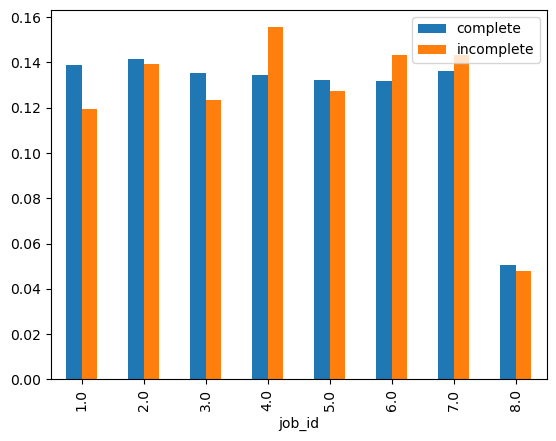

In [59]:
sg = (students.groupby('job_id').count()['uuid']/len(students)).rename('complete')
mg = (missing_num_course_taken.groupby('job_id').count()['uuid']/len(missing_num_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

<Axes: xlabel='sex'>

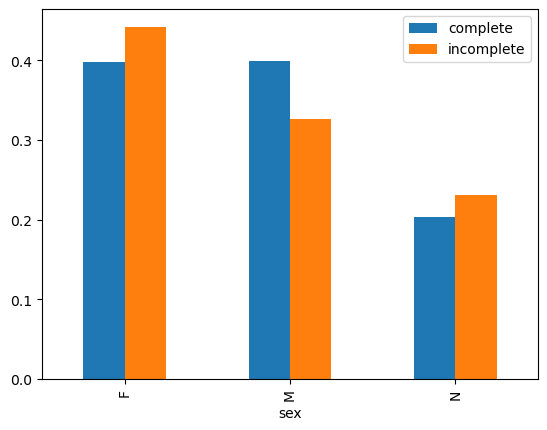

In [58]:
sg = (students.groupby('sex').count()['uuid']/len(students)).rename('complete')
mg = (missing_num_course_taken.groupby('sex').count()['uuid']/len(missing_num_course_taken)).rename('incomplete')
df = pd.concat([sg, mg], axis=1)
df.plot.bar()

There is no obvious pattern from these graphs and there is nothing out of distribution.  Therefore this is MAR data. Even though its more than the job_id MAR data it is still not as large of a chunk of data that would impact the outcome if I delete it. 

In [60]:
missing_data = pd.concat([missing_data, missing_num_course_taken])
students = students.dropna(subset=['num_course_taken'])

In [61]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4293 non-null   float64
 7   time_spent_hrs          4293 non-null   float64
 8   age                     4744 non-null   float64
 9   email                   4744 non-null   object 
 10  street                  4744 non-null   object 
 11  city                    4744 non-null   object 
 12  state                   4744 non-null   object 
 13  zip                     4744 non-null   object 
dtypes: float64(5), int64(1), object(8)
memor

### `Current Carrer Path ID`

In [63]:
missing_career_path_id = students[students[['current_career_path_id']].isnull().any(axis=1)]
missing_career_path_id.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,email,street,city,state,zip
15,16,Norene Dalton,1976-04-30,F,6.0,0.0,NaN,NaN,47.0,norene_dalton9509@hmail.com,130 Wishing Essex,Branch,Ohio,13616
19,20,Sofia van Steenbergen,1990-02-21,N,7.0,13.0,NaN,NaN,33.0,vansteenbergen8482@inlook.com,634 Clear Barn Dell,Beaman,Georgia,33288
30,31,Christoper Warner,1989-12-28,M,2.0,5.0,NaN,NaN,33.0,warner5906@coldmail.com,556 Stony Highlands,Drain,Illinois,01973
49,50,Antony Horne,1996-05-29,M,3.0,2.0,NaN,NaN,26.0,antony577@coldmail.com,P.O. Box 78685,Lenox,Texas,15516
54,55,Omar Bunk,1955-11-08,M,3.0,14.0,NaN,NaN,67.0,omar1245@coldmail.com,445 Dale Hollow,Vermont village,South Carolina,28329


I noticed this on the last info dump but I wanted to see if it translated in the missing dataframe.  current_career_path_id and time_spend_hours are null together.  This would mean that both are structually missing. To resolve this, I will set current_career_path_id to a new id that will indicate no current career path, and I will set time_spent_hrs to 0 to indicate no hours spent.

In [64]:
students['current_career_path_id'].unique()

array([ 1.,  8.,  9.,  3.,  6., 10.,  5., nan,  4.,  7.,  2.])

In [67]:
students['current_career_path_id'] = np.where(students['current_career_path_id'].isnull(), 0, students['current_career_path_id'])
students['time_spent_hrs'] = np.where(students['time_spent_hrs'].isnull(), 0, students['time_spent_hrs'])

In [68]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   float64
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   float64
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   email                   4744 non-null   object 
 10  street                  4744 non-null   object 
 11  city                    4744 non-null   object 
 12  state                   4744 non-null   object 
 13  zip                     4744 non-null   object 
dtypes: float64(5), int64(1), object(8)
memor

Now that I have gotten rid of a null values I can convert the id categories to integers

In [79]:
students['job_id'] = students['job_id'].astype(int)
students['current_career_path_id'] = students['current_career_path_id'].astype(int)

In [80]:
students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int64  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int64  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   email                   4744 non-null   object 
 10  street                  4744 non-null   object 
 11  city                    4744 non-null   object 
 12  state                   4744 non-null   object 
 13  zip                     4744 non-null   object 
dtypes: float64(3), int64(3), object(8)
memor

## Courses Table

In [71]:
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


In [72]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   career_path_id     10 non-null     int64 
 1   career_path_name   10 non-null     object
 2   hours_to_complete  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


The only thing that really needs to be done here is to add the new career path that I created in the students table. 

In [73]:
undecided = {'career_path_id': 0,
                  'career_path_name': 'undecided',
                  'hours_to_complete': 0}
courses.loc[len(courses)] = undecided
display(courses)

,career_path_id,career_path_name,hours_to_complete
0,1,data scientist,20
1,2,data engineer,20
2,3,data analyst,12
3,4,software engineering,25
4,5,backend engineer,18
5,6,frontend engineer,20
6,7,iOS developer,27
7,8,android developer,27
8,9,machine learning engineer,35
9,10,ux/ui designer,15


## Student Jobs Table

In [74]:
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


In [76]:
student_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   job_id        13 non-null     int64 
 1   job_category  13 non-null     object
 2   avg_salary    13 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 440.0+ bytes


The only thing that needs to be fixed in this table is that there are 3 duplicates. 

In [77]:
student_jobs.drop_duplicates(inplace=True)
display(student_jobs)

,job_id,job_category,avg_salary
0,1,analytics,86000
1,2,engineer,101000
2,3,software developer,110000
3,4,creative,66000
4,5,financial services,135000
5,6,education,61000
6,7,HR,80000
7,8,student,10000
8,9,healthcare,120000
9,0,other,80000


# Create the Output CSV
Use the cleaned tables to produce an analytics-ready SQLite database and flat CSV file. The final CSV should contain all the data the analysts might need in a single table. <br>

I want to keep the data in the students table since it is the largest. I will left join to that one. 

In [82]:
df = students.merge(courses, left_on='current_career_path_id', right_on = 'career_path_id', how='left')
df = df.merge(student_jobs, on = 'job_id', how='left')
df.head()

,uuid,name,dob,sex,job_id,num_course_taken,current_career_path_id,time_spent_hrs,age,email,street,city,state,zip,career_path_id,career_path_name,hours_to_complete,job_category,avg_salary
0,1,Annabelle Avery,1943-07-03,F,7,6.0,1,4.99,79.0,annabelle_avery9376@woohoo.com,303 N Timber Key,Irondale,Wisconsin,84736,1,data scientist,20,HR,80000
1,2,Micah Rubio,1991-02-07,M,7,5.0,8,4.40,32.0,rubio6772@hmail.com,767 Crescent Fair,Shoals,Indiana,37439,8,android developer,27,HR,80000
2,3,Hosea Dale,1989-12-07,M,7,8.0,8,6.74,33.0,hosea_dale8084@coldmail.com,P.O. Box 41269,St. Bonaventure,Virginia,83637,8,android developer,27,HR,80000
3,4,Mariann Kirk,1988-07-31,F,6,7.0,9,12.31,34.0,kirk4005@hmail.com,517 SE Wintergreen Isle,Lane,Arkansas,82242,9,machine learning engineer,35,education,61000
4,5,Lucio Alexander,1963-08-31,M,7,14.0,3,5.64,59.0,alexander9810@hmail.com,18 Cinder Cliff,Doyles borough,Rhode Island,73737,3,data analyst,12,HR,80000


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4744 entries, 0 to 4743
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   uuid                    4744 non-null   int64  
 1   name                    4744 non-null   object 
 2   dob                     4744 non-null   object 
 3   sex                     4744 non-null   object 
 4   job_id                  4744 non-null   int64  
 5   num_course_taken        4744 non-null   float64
 6   current_career_path_id  4744 non-null   int64  
 7   time_spent_hrs          4744 non-null   float64
 8   age                     4744 non-null   float64
 9   email                   4744 non-null   object 
 10  street                  4744 non-null   object 
 11  city                    4744 non-null   object 
 12  state                   4744 non-null   object 
 13  zip                     4744 non-null   object 
 14  career_path_id          4744 non-null   

In [84]:
con.close()